In [1]:
#%% Import modules
from IPython import get_ipython
import os
import numpy as np   
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import matplotlib.colors as mcolors 
import matplotlib.style as mstyle
import pandas as pandas
from netCDF4 import Dataset
import cmocean
import datetime
import scipy as scipy
import pandas
import xarray as xr              
from scipy import stats,signal
from matplotlib import ticker,colors


print("done importing modules")

done importing modules


In [2]:
#%% Define file location

WRF_DIRECTORY = "/projects/storm/mgomez/idealSims/sst_31_skipd01_skipCoLES_ndg/"
WRF_DIRECTORY = "/projects/storm/mgomez/idealSims/sst_31md_skipd01_skipCoLES_ndg/"


input_largeDomain = "wrfrst_d01_2000-01-01_00:00:13" 

modified_input = input_largeDomain + "_mod"


In [3]:
#%% Extract variables from input of large domain
ds=xr.open_dataset(WRF_DIRECTORY+input_largeDomain,decode_times=False)
# Wind speed
u = ds['U_1']
u_np = np.array(u[:,:,:,:])
v = ds['V_1']
v_np = np.array(v[:,:,:,:])
# Sea surface temperautre
sst = ds['TSK']
# Land or sea mask
xland = ds['XLAND']
# Coriolis terms
coriolis_cos = ds['E']
coriolis_sin = ds['F']
# Height variables
ph = ds['PH_1']
ph = np.array(ph[0,:,:,:])
phb = ds['PHB']
phb = np.array(phb[0,:,:,:])
height_stag = (ph+phb)/9.81
ph = 0.0
phb = 0.0
height_agl = (height_stag[1:,:,:]+height_stag[0:-1,:,:])/2
height_agl = np.array(np.mean(np.mean(height_agl,axis=1),axis=1))
height_stag = np.mean(np.mean(height_stag,axis=1),axis=1)
# Domain dimensions
dx = ds.DX


print("done extracting variables for input, large domain simulation")
ds.close()

done extracting variables for input, large domain simulation


In [4]:
#%% Parameters for hurricane
# Height of zero wind speed
z_0 = 20000 # m
# Radius of zero wind speed
r_0 = 412500 #350000 # m
# Maximum wind speed
v_max = 15 # m/s
#v_max = 50 # m/s

# Radius of maximum wind speed
r_max = 82500*r_0/412500 # m
# Coriolis parameter for f-plane
lat = 20
Omega = 7.2921*(10**-5) # rad/s
f = 2*Omega*np.sin(lat*np.pi/180) # 1/s

# Sea surface temperature
SST_hurr = 31 + 273.15
sst[:,:,:] = SST_hurr

print('SST is %f deg C' % (SST_hurr - 273.15))

# Change from Land to Sea so that iscflx = 1 works
xland[:,:,:] = 2

# Set Coriolis in simulations
coriolis_cos[:,:,:] = 2*Omega*np.cos(lat*2*np.pi/360)
coriolis_sin[:,:,:] = 2*Omega*np.sin(lat*2*np.pi/360)


SST is 31.000000 deg C


In [5]:
#%% Create grid in cartesian coordinates
ddxx = dx
ddzz = 5
x = np.arange(-1*r_0,r_0,ddxx)
y = np.arange(-1*r_0,r_0,ddxx)
z_temp= np.arange(0,z_0,ddzz)
z = np.zeros(len(z_temp))
for i in np.arange(len(z)):
    if i==0:
        dz_temp = ddzz
        z[i] = z_temp[i]
    else:
        if z[i-1]<=z_0:
            dz_temp += 2.5
            z[i] = z[i-1] + dz_temp
        else:
            break
z = z[:np.argmax(z)]

In [6]:
#%% Tangential velocity in vortex using cartensian coordinates
# Initialize array
v_t_xy = np.zeros([len(z),len(y),len(x)])

# Calculate tangential veloctity at each location
for ix in np.arange(0,len(x)):
    for iy in np.arange(0,len(y)):
        for iz in np.arange(0,len(z)):
            # Radius at given (x,y) location
            rr = np.sqrt(x[ix]**2 + y[iy]**2)
            
            # Below desired height
            if z[iz] <= z_0:
                # Tangential velocity inside of max radius 
                if rr<=r_0:
                    # Intensity decays with height
                    I = (z_0-z[iz])/z_0
                    # Term 1
                    term1 = (v_max**2)*((rr/r_max)**2)
                    # Term 2
                    term2 = ( (2*r_max/(rr+r_max))**3 ) - ( (2*r_max/(r_0+r_max))**3 )
                    # Term 3
                    term3 = (f**2)*(rr**2)/4
                    # Term 4
                    term4 = f*rr/2
                    
                    # Tangential velocity
                    v_t_xy[iz,iy,ix] = I*((term1*term2 + term3)**0.5 - term4 )

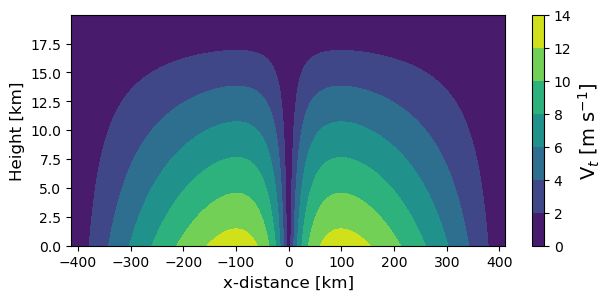

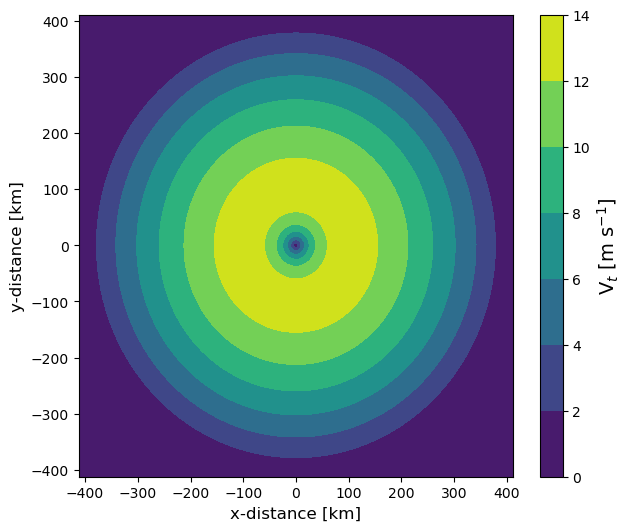

In [7]:
#%% Plot of tangential velocity
# X-Z slice
plt.figure(figsize=(7,3))
plt.contourf(x/1000,z/1000,v_t_xy[:,int(0.5*len(y)),:])
plt.xlabel('x-distance [km]',fontsize=12)
plt.ylabel('Height [km]',fontsize=12)
cbar = plt.colorbar()
cbar.set_label(r'V$_t$ [m s$^{-1}$]',fontsize=14)
plt.show()
plt.close()

# X-Y Planview
plt.figure(figsize=(7,6))
plt.contourf(x/1000,y/1000,v_t_xy[0,:,:])
plt.xlabel('x-distance [km]',fontsize=12)
plt.ylabel('y-distance [km]',fontsize=12)
cbar = plt.colorbar()
cbar.set_label(r'V$_t$ [m s$^{-1}$]',fontsize=14)
plt.show()
plt.close()

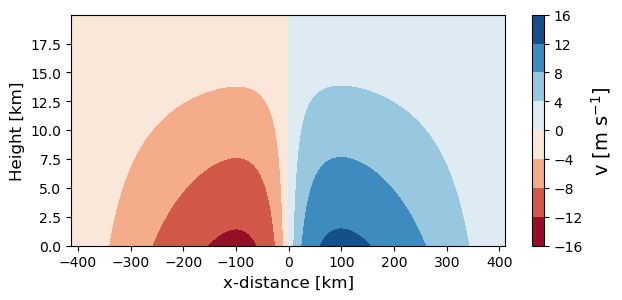

In [8]:
#%% Calcualate zonal and meridional components of wind speed at each location
# Magnitude of tangential velocity
v_t_magnitude = np.abs(v_t_xy)

# Initialize arrays
u_hurr = np.zeros(np.shape(v_t_xy))
v_hurr = np.zeros(np.shape(v_t_xy))

# Calculate zonal and meridional veloctity components at each location
for ix in np.arange(0,len(x)):
    for iy in np.arange(0,len(y)):
        # Hurricanes are cyclonic systems
        
        # Determine quadrant in cartesian coordinates
        if (x[ix]>0.0001) & (y[iy]>0.0001):
            # Angle to x-axis
            thet = np.arctan(y[iy]/x[ix])
            # Zonal velocity component
            u_hurr[:,iy,ix] = -1*v_t_magnitude[:,iy,ix]*np.sin(thet)
            # Meridional velocity component
            v_hurr[:,iy,ix]= v_t_magnitude[:,iy,ix]*np.cos(thet)
        elif (x[ix]<-0.0001) & (y[iy]>0.0001):
            # Angle to x-axis
            thet = np.arctan(np.abs(y[iy]/x[ix]))
            # Zonal velocity component
            u_hurr[:,iy,ix] = -1*v_t_magnitude[:,iy,ix]*np.sin(thet)
            # Meridional velocity component
            v_hurr[:,iy,ix] = -1*v_t_magnitude[:,iy,ix]*np.cos(thet)
        elif (x[ix]<-0.0001) & (y[iy]<-0.0001):
            # Angle to y-axis
            thet = np.arctan(np.abs(x[ix]/y[iy]))
            # Zonal velocity component
            u_hurr[:,iy,ix] = v_t_magnitude[:,iy,ix]*np.cos(thet)
            # Meridional velocity component
            v_hurr[:,iy,ix] = -1*v_t_magnitude[:,iy,ix]*np.sin(thet)
        elif (x[ix]>0.0001) & (y[iy]<-0.0001):
            # Angle to y-axis
            thet = np.arctan(np.abs(y[iy]/x[ix]))
            # Zonal velocity component
            u_hurr[:,iy,ix] = v_t_magnitude[:,iy,ix]*np.sin(thet)
            # Meridional velocity component
            v_hurr[:,iy,ix] = v_t_magnitude[:,iy,ix]*np.cos(thet)
        
# Plot velocity field
# X-Z slice
plt.figure(figsize=(7,3))
plt.contourf(x/1000,z/1000,v_hurr[:,int(0.5*len(y)),:],cmap = plt.cm.RdBu)
plt.xlabel('x-distance [km]',fontsize=12)
plt.ylabel('Height [km]',fontsize=12)
cbar = plt.colorbar()
cbar.set_label(r'v [m s$^{-1}$]',fontsize=14)
plt.show()
plt.close()

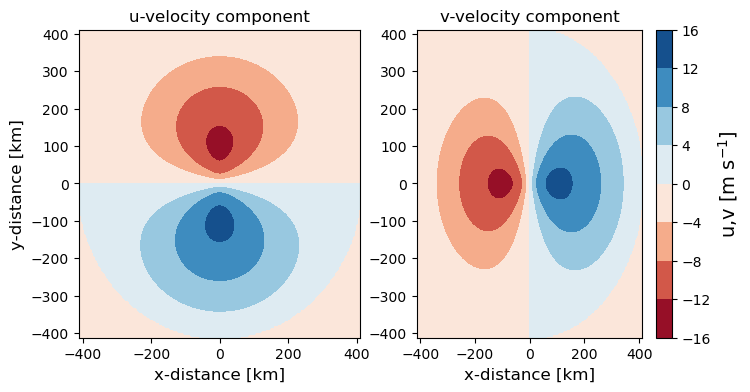

In [9]:
#%% X-Y Planview
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('u-velocity component')
plt.contourf(x/1000,y/1000,u_hurr[0,:,:],cmap = plt.cm.RdBu)
plt.xlabel('x-distance [km]',fontsize=12)
plt.ylabel('y-distance [km]',fontsize=12)
plt.subplot(1,2,2)
plt.title('v-velocity component')
plt.contourf(x/1000,y/1000,v_hurr[0,:,:],cmap = plt.cm.RdBu)
plt.xlabel('x-distance [km]',fontsize=12)
cbar = plt.colorbar()
cbar.set_label(r'u,v [m s$^{-1}$]',fontsize=14)
plt.show()
plt.close()

In [10]:
#%% Interpolate from hurricane grid to WRF grid
# Find center of domain
ix_mid = int(0.5*(np.shape(u)[3]-1))
iy_mid = int(0.5*(np.shape(v)[2]-1))
L_yy = int(0.5*np.shape(u_hurr)[1])
L_xx = int(0.5*np.shape(u_hurr)[2])

# RE-WRITE velocity field for each vertical level
for iz in np.arange(len(height_agl)):
    # Find closest vertical level
    i_close = np.argmin(np.abs(z - height_agl[iz]))
    if i_close==len(z)-1:
        i_close = i_close-1
    a = np.abs(z[i_close]-height_agl[iz])/(z[i_close+1] - z[i_close])
    b = 1-a
    
    # Re-write zonal velocity field
    u[0,iz,iy_mid-L_yy:iy_mid+L_yy,ix_mid-L_xx:ix_mid+L_xx] = b*u_hurr[i_close,:,:] + a*u_hurr[i_close+1,:,:]
    
    # Re-write meridional velocity field
    v[0,iz,iy_mid-L_yy:iy_mid+L_yy,ix_mid-L_xx:ix_mid+L_xx] = b*v_hurr[i_close,:,:] + a*v_hurr[i_close+1,:,:]

In [11]:
#%% Rewrite wrfinput file using extrapolated, turbulent fields
ds=xr.open_dataset(WRF_DIRECTORY+input_largeDomain)
# Re-write zonal winds
#ds['U']=xr.where((ds['U']>-10000),u_stag_LG,ds['U'])
ds = ds.drop_vars('U_1')
ds = ds.assign(U_1=u)
ds = ds.drop_vars('U_2')
ds = ds.assign(U_2=u)
# Re-write meridional winds
#ds['V']=xr.where((ds['V']<10000),v_stag_LG,v_stag_extrap)
ds = ds.drop_vars('V_1')
ds = ds.assign(V_1=v)
ds = ds.drop_vars('V_2')
ds = ds.assign(V_2=v)
# Re-write sea surface temperature
ds = ds.drop_vars('TSK')
ds = ds.assign(TSK=sst)
# Re-write land sea mask
ds = ds.drop_vars('XLAND')
ds = ds.assign(XLAND=xland)
# Re-write Coriolis terms
ds = ds.drop_vars('E')
ds = ds.assign(E=coriolis_cos)
ds = ds.drop_vars('F')
ds = ds.assign(F=coriolis_sin)
# Re-write file
ds.to_netcdf(WRF_DIRECTORY+modified_input)
ds.close()

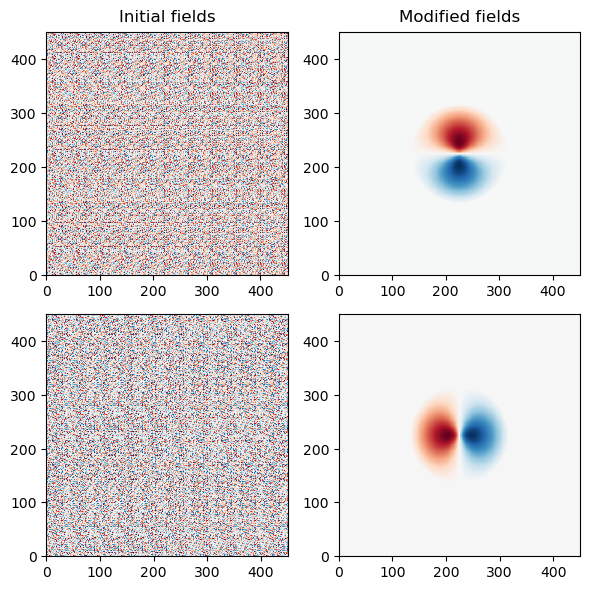

SST init = 29.282800 C; SST mod = 30.999994 C
XLAND init = 2.000000 ; XLAND mod = 2.000000 
Latitude for Coriolis terms was 43.288599 deg and now is 20.000000 deg


In [12]:
#%% Verify the fields are modified
# Extract variables from initial input file
ds=xr.open_dataset(WRF_DIRECTORY+input_largeDomain)
u_init = ds['U_1']
v_init = ds['V_1']
sst_init = ds['TSK']
xland_init = ds['XLAND']
CO_init = ds['F']
ds.close()
ds = 0

# Extract variables from modified input file
ds=xr.open_dataset(WRF_DIRECTORY+modified_input)
u_mod = ds['U_1']
v_mod = ds['V_1']
sst_mod = ds['TSK']
xland_mod = ds['XLAND']
CO_mod = ds['F']
ds.close()
ds = 0

# Figures
plt.figure(figsize=(6,6))
# Initial files
plt.subplot(2,2,1)
plt.title('Initial fields',x=0.5,y=1.01)
plt.pcolormesh(u_init[0,13,:,:],cmap = plt.cm.RdBu)
plt.subplot(2,2,3)
plt.pcolormesh(v_init[0,13,:,:],cmap = plt.cm.RdBu)
# Modified files
plt.subplot(2,2,2)
plt.title('Modified fields',x=0.5,y=1.01)
plt.pcolormesh(u_mod[0,13,:,:],cmap = plt.cm.RdBu)
plt.subplot(2,2,4)
plt.pcolormesh(v_mod[0,13,:,:],cmap = plt.cm.RdBu)

plt.tight_layout()
plt.show()
plt.close()

print("SST init = %f C; SST mod = %f C" % (np.median(sst_init)-273.15,np.median(sst_mod)-273.15))
print("XLAND init = %f ; XLAND mod = %f " % (np.median(xland_init),np.median(xland_mod)))
print("Latitude for Coriolis terms was %f deg and now is %f deg" % 
      (np.arcsin(np.min(CO_init)/(2*Omega))*180/np.pi,np.arcsin(np.min(CO_mod)/(2*Omega))*180/np.pi))